¿Es estable el  suministro generado por el mix
renovable tanto por rango horario como
por estaciones?​


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import StringIO
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import pearsonr
import statsmodels.api as sm

In [5]:
# Cargar el CSV
df = pd.read_csv("../Data/energy_grouped.csv", parse_dates=['time'])

# 1. Eliminar filas duplicadas
df = df.drop_duplicates()

# 2. Convertir columnas numéricas (forzar errores a NaN si aparecen strings)
for col in df.columns:
    if col != 'time':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Eliminar columnas con valores faltantes críticos o que estén completamente vacías
df = df.dropna(axis=1, how='all')  # elimina columnas totalmente vacías

# 4. Opcional: eliminar o imputar filas con valores NaN
# df = df.dropna()  # eliminar
# o bien imputar:
# df.fillna(method='ffill', inplace=True)

# 5. Validar valores extremos
# Por ejemplo, limpiar spot_price_daily si hay valores anómalos
q_low = df["spot_price_daily"].quantile(0.01)
q_hi  = df["spot_price_daily"].quantile(0.99)
df = df[(df["spot_price_daily"] >= q_low) & (df["spot_price_daily"] <= q_hi)]

# 6. Reiniciar el índice
df.reset_index(drop=True, inplace=True)

# Guardar el dataset limpio
df.to_csv("dataset_limpio.csv", index=False)

In [9]:
# Cargar el dataset
df = pd.read_csv('../Data/dataset_limpio.csv', parse_dates=['time'])

In [11]:
print(df.columns)

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual',
       'spot_price_daily', 'total_generation_fosil', 'total_generation_solar',
       'total_generation_eolica', 'total_generation_otras_renovables',
       'total_generation_hidraulica'

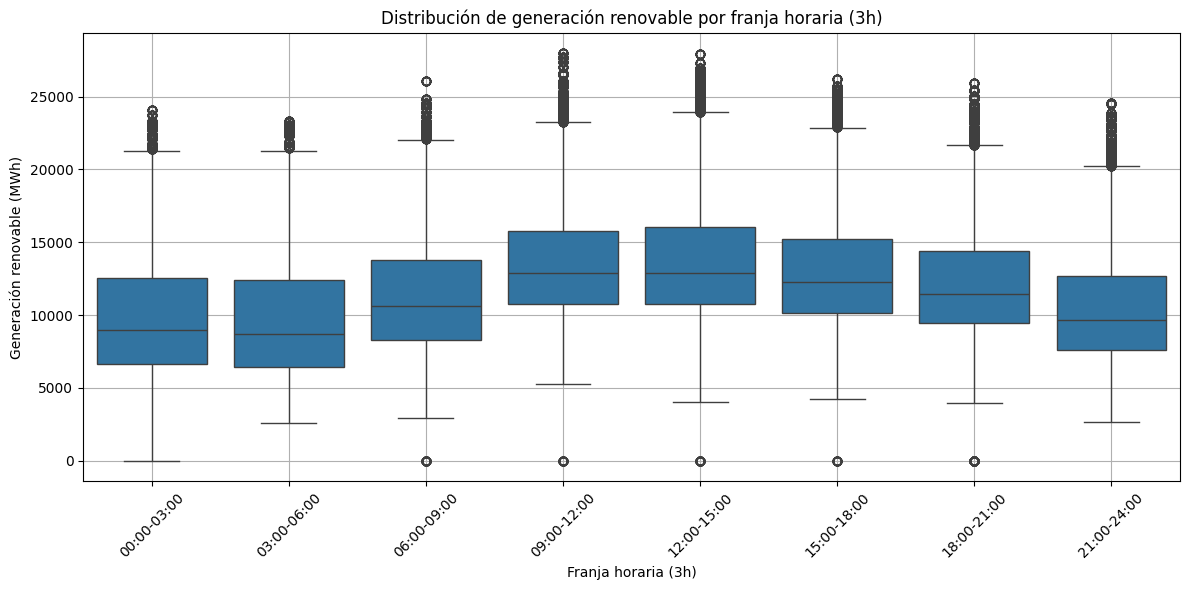

In [12]:
# Asegúrate de que 'time' es tipo datetime
df['time'] = pd.to_datetime(df['time'])

# Crear la columna de franjas de 3 horas
def obtener_franja_3h(dt):
    inicio = dt.hour - (dt.hour % 3)
    fin = inicio + 3
    return f"{inicio:02d}:00-{fin:02d}:00"

df['franja_horaria_3h'] = df['time'].apply(obtener_franja_3h)

# Boxplot de la generación renovable por franja horaria
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='franja_horaria_3h', y='total_generation_renovable',
            order=[f"{i:02d}:00-{i+3:02d}:00" for i in range(0, 24, 3)])
plt.title('Distribución de generación renovable por franja horaria (3h)')
plt.xlabel('Franja horaria (3h)')
plt.ylabel('Generación renovable (MWh)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

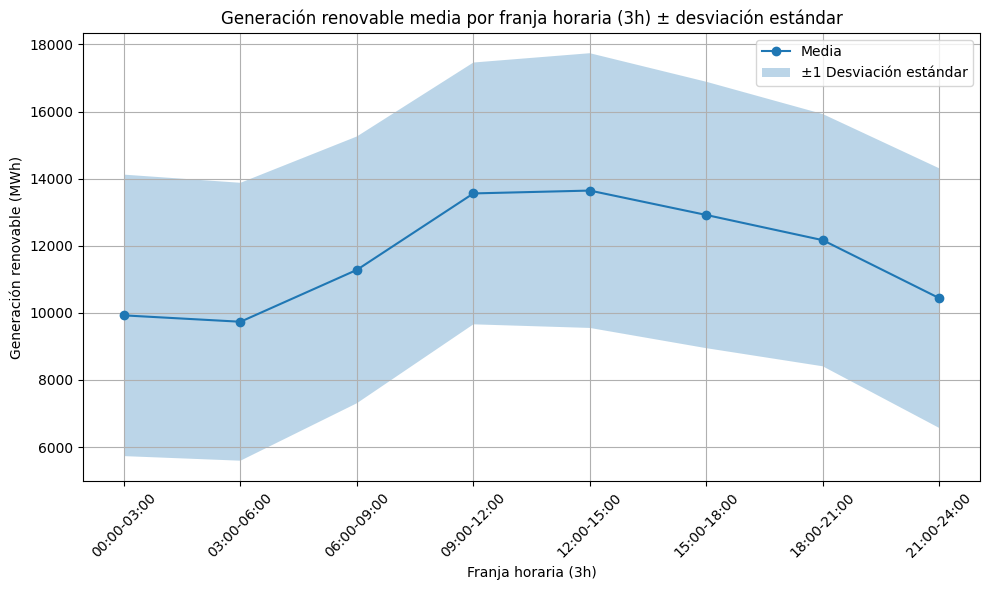

In [13]:
# Asegúrate de que 'time' es datetime
df['time'] = pd.to_datetime(df['time'])

# Crear franja horaria de 3 horas
def obtener_franja_3h(dt):
    inicio = dt.hour - (dt.hour % 3)
    fin = inicio + 3
    return f"{inicio:02d}:00-{fin:02d}:00"

df['franja_horaria_3h'] = df['time'].apply(obtener_franja_3h)

# Agrupar por franja horaria y calcular media y desviación estándar
grouped = df.groupby('franja_horaria_3h')['total_generation_renovable'].agg(['mean', 'std']).reindex(
    [f"{i:02d}:00-{i+3:02d}:00" for i in range(0, 24, 3)]
)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(grouped.index, grouped['mean'], label='Media', marker='o')
plt.fill_between(grouped.index,
                 grouped['mean'] - grouped['std'],
                 grouped['mean'] + grouped['std'],
                 alpha=0.3, label='±1 Desviación estándar')

plt.title('Generación renovable media por franja horaria (3h) ± desviación estándar')
plt.xlabel('Franja horaria (3h)')
plt.ylabel('Generación renovable (MWh)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

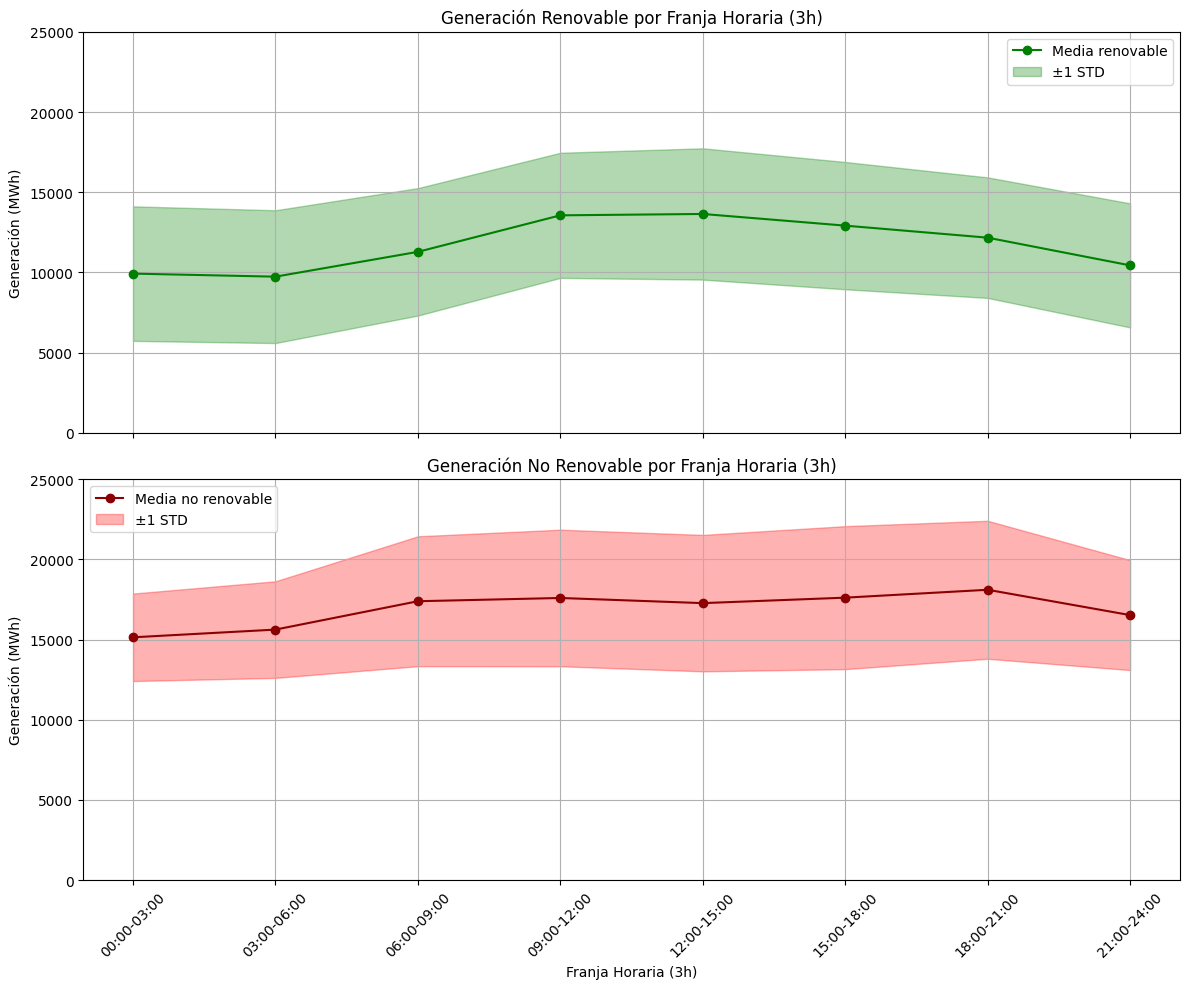

In [15]:
# Asegúrate de que 'time' es datetime
df['time'] = pd.to_datetime(df['time'])

# Crear franja horaria de 3 horas
def obtener_franja_3h(dt):
    inicio = dt.hour - (dt.hour % 3)
    fin = inicio + 3
    return f"{inicio:02d}:00-{fin:02d}:00"

df['franja_horaria_3h'] = df['time'].apply(obtener_franja_3h)

# Orden correcto de las franjas
orden_franjas = [f"{i:02d}:00-{i+3:02d}:00" for i in range(0, 24, 3)]

# Agrupar y calcular estadísticas
renovable_stats = df.groupby('franja_horaria_3h')['total_generation_renovable'].agg(['mean', 'std']).reindex(orden_franjas)
no_renovable_stats = df.groupby('franja_horaria_3h')['total_generation_no_renovable'].agg(['mean', 'std']).reindex(orden_franjas)

# Crear figura y ejes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Gráfico 1: Renovables
ax1.plot(renovable_stats.index, renovable_stats['mean'], label='Media renovable', color='green', marker='o')
ax1.fill_between(renovable_stats.index,
                 renovable_stats['mean'] - renovable_stats['std'],
                 renovable_stats['mean'] + renovable_stats['std'],
                 color='green', alpha=0.3, label='±1 STD')
ax1.set_title('Generación Renovable por Franja Horaria (3h)')
ax1.set_ylabel('Generación (MWh)')
ax1.set_ylim(0, 25000)
ax1.grid(True)
ax1.legend()

# Gráfico 2: No renovables
ax2.plot(no_renovable_stats.index, no_renovable_stats['mean'], label='Media no renovable', color='darkred', marker='o')
ax2.fill_between(no_renovable_stats.index,
                 no_renovable_stats['mean'] - no_renovable_stats['std'],
                 no_renovable_stats['mean'] + no_renovable_stats['std'],
                 color='red', alpha=0.3, label='±1 STD')
ax2.set_title('Generación No Renovable por Franja Horaria (3h)')
ax2.set_xlabel('Franja Horaria (3h)')
ax2.set_ylabel('Generación (MWh)')
ax2.set_ylim(0, 25000)
ax2.grid(True)
ax2.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

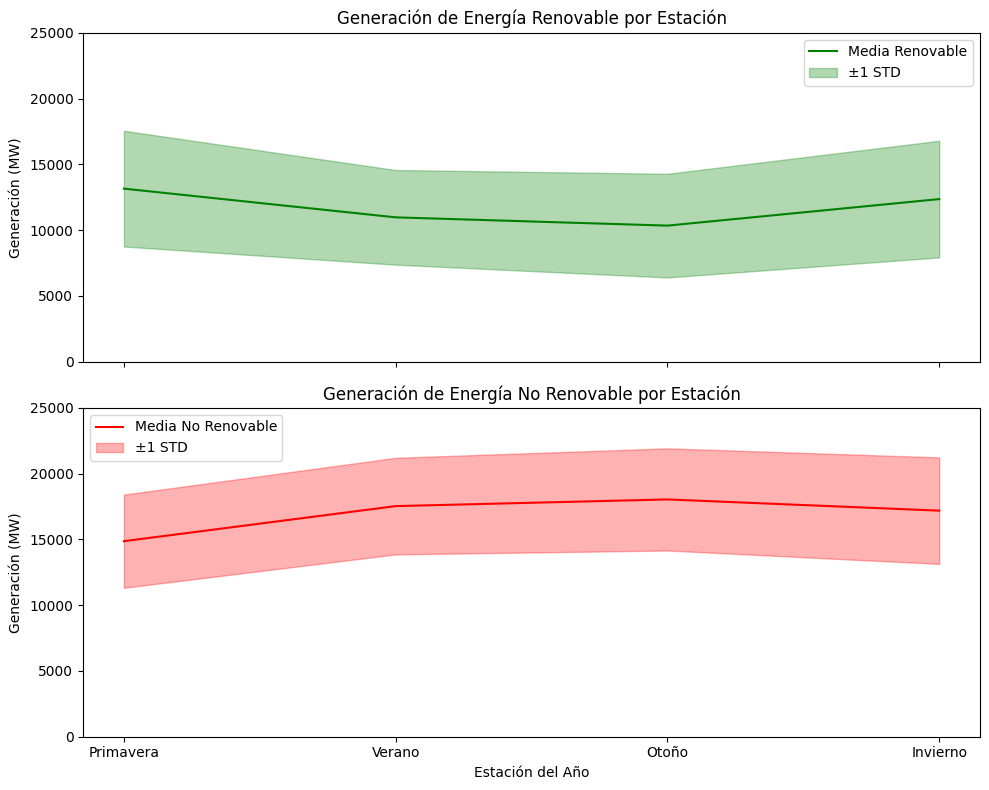

In [17]:
# Asegúrate de que 'time' esté en formato datetime
df['time'] = pd.to_datetime(df['time'])

# Crear columna 'estacion' a partir del mes
def asignar_estacion(fecha):
    mes = fecha.month
    if mes in [3, 4, 5]:
        return 'Primavera'
    elif mes in [6, 7, 8]:
        return 'Verano'
    elif mes in [9, 10, 11]:
        return 'Otoño'
    else:
        return 'Invierno'

df['estacion'] = df['time'].apply(asignar_estacion)

# Agrupar por estación y calcular media y desviación estándar
agrupado = df.groupby('estacion').agg({
    'total_generation_renovable': ['mean', 'std'],
    'total_generation_no_renovable': ['mean', 'std']
}).reindex(['Primavera', 'Verano', 'Otoño', 'Invierno'])

# Extraer valores
estaciones = agrupado.index
media_renovable = agrupado['total_generation_renovable']['mean']
std_renovable = agrupado['total_generation_renovable']['std']
media_no_renovable = agrupado['total_generation_no_renovable']['mean']
std_no_renovable = agrupado['total_generation_no_renovable']['std']

# Crear gráficos
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Gráfico 1: Renovable
axs[0].plot(estaciones, media_renovable, label='Media Renovable', color='green')
axs[0].fill_between(estaciones,
                    media_renovable - std_renovable,
                    media_renovable + std_renovable,
                    color='green', alpha=0.3, label='±1 STD')
axs[0].set_title('Generación de Energía Renovable por Estación')
axs[0].set_ylabel('Generación (MW)')
axs[0].set_ylim(0, 25000)
axs[0].legend()

# Gráfico 2: No Renovable
axs[1].plot(estaciones, media_no_renovable, label='Media No Renovable', color='red')
axs[1].fill_between(estaciones,
                    media_no_renovable - std_no_renovable,
                    media_no_renovable + std_no_renovable,
                    color='red', alpha=0.3, label='±1 STD')
axs[1].set_title('Generación de Energía No Renovable por Estación')
axs[1].set_ylabel('Generación (MW)')
axs[1].set_ylim(0, 25000)
axs[1].set_xlabel('Estación del Año')
axs[1].legend()

plt.tight_layout()
plt.show()